# Road to Generative AI - Part 2: Multi-Layer Perceptron

## Introduction

The purpose of this notebook is to explore the capabilities of Generative AI. In the [first part](https://tdody.github.io//bigram-and-nn/) of this series, we explored the concept of Generative AI and built a simple model that generates text using a bigram model and a single-layer NN. In this part, we will build a more complex model using Multi-Layer Perceptron (MLP) to generate text.

The reason behind using MLP is that N-gram models suffer from the curse of dimensionality. As the size of the n-gram increases, the number of possible n-grams grows exponentially. This makes it difficult to store and process the n-grams. In contrast, MLP can learn the patterns in the data and generate text without the need to store all possible n-grams.

In the paper "A Neural Probabilistic Language Model" by Yoshua Bengio et al., the authors proposed a neural network-based language model that can learn to predict the next word in a sentence. We are going to use a similar approach but our focus is on generating the next character in a sequence of characters.

## Dataset

We will use a dataset containing common bird names. Our source data can be found [here](https://www.kaggle.com/datasets/thepushkarp/common-bird-names).

In [144]:
DATASET_PATH = "./datasets/birds/birds.csv"

birds = open(DATASET_PATH, "r").read().splitlines()

print("First 10 birds in the dataset:")
print(", ".join(birds[:10]))
print(f"There are {len(birds):,d} birds in the dataset.")

min_length = map(len, birds)
max_length = map(len, birds)
print(f"The shortest character name has {min(min_length)} birds.")
print(f"The longest character name has {max(max_length)} birds.")

First 10 birds in the dataset:
Abbott's babbler, Abbott's booby, Abbott's starling, Abbott's sunbird, Abd al-Kuri sparrow, Abdim's stork, Aberdare cisticola, Aberrant bush warbler, Abert's towhee, Abyssinian catbird
There are 10,976 birds in the dataset.
The shortest character name has 3 birds.
The longest character name has 35 birds.


In [145]:
from unidecode import unidecode

def clean_name(name):
    # Remove leading and trailing whitespaces
    # Convert to lowercase
    # Remove accents
    # Remove special characters
    # Replace spaces with underscores

    name = name.strip().lower()
    # replace special characters with a space
    name = ''.join(char if char.isalnum() or char.isspace() else ' ' for char in name)
    name = name.replace("`", "_")  # Remove apostrophes
    name = name.replace(" ", "_")
    name = unidecode(name)
    return name

In [146]:
# clean a few random names from the dataset
import numpy as np
rdm_indexes = np.random.randint(0, len(birds), 10)

print("Cleaning process:")
for i in rdm_indexes:
    name = birds[i]
    cleaned_name = clean_name(name)
    print(f"Original: {name} -> Cleaned: {cleaned_name}")

Cleaning process:
Original: Blue-collared parrot -> Cleaned: blue_collared_parrot
Original: Mindanao lorikeet -> Cleaned: mindanao_lorikeet
Original: Club-winged manakin -> Cleaned: club_winged_manakin
Original: Purple-bearded bee-eater -> Cleaned: purple_bearded_bee_eater
Original: Western banded snake eagle -> Cleaned: western_banded_snake_eagle
Original: Dusky-headed parakeet -> Cleaned: dusky_headed_parakeet
Original: White-throated swift -> Cleaned: white_throated_swift
Original: Sapphire flycatcher -> Cleaned: sapphire_flycatcher
Original: Rusty-backed spinetail -> Cleaned: rusty_backed_spinetail
Original: Dead Sea sparrow -> Cleaned: dead_sea_sparrow


In [147]:
# clean all names in the dataset
birds = list(map(clean_name, birds))

# create a mapping from tokens to indices
unique_tokens = set([c for w in birds for c in w])
SPECIAL_TOKEN = "."
index_to_token = {i: t for i, t in enumerate(unique_tokens, start=1)}
token_to_index = {v: k for k, v in index_to_token.items()}
index_to_token[0] = SPECIAL_TOKEN
token_to_index[SPECIAL_TOKEN] = 0

# log information about the tokenization
print(f"Number of unique tokens: {len(unique_tokens)}")
print(", ".join(sorted(unique_tokens)))
print(f"Token mapping: {index_to_token}")

Number of unique tokens: 28
_, `, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z
Token mapping: {1: 't', 2: 'u', 3: 'x', 4: 'a', 5: 'n', 6: '`', 7: 'z', 8: 'l', 9: 'c', 10: 'r', 11: 'd', 12: '_', 13: 'v', 14: 'k', 15: 's', 16: 'e', 17: 'q', 18: 'b', 19: 'h', 20: 'g', 21: 'y', 22: 'j', 23: 'f', 24: 'p', 25: 'm', 26: 'w', 27: 'o', 28: 'i', 0: '.'}


## Model Architecture

The main limitation of the bigram model is its scalability. As we increase the context size, the number of unique n-grams grows exponentially, making it difficult to store and process them. To overcome this limitation, we will use a Multi-Layer Perceptron (MLP) model.

The figure below shows the architecture of the MLP model. The model consists of an embedding layer $C$. The embeddings are fed into a hidden layer $H$ with a $tanh$ activation function. The output of the hidden layer is fed into the output layer $O$ with a softmax activation function. The output layer generates the probability distribution of the next character in the sequence.

<figure>
    <img src="./assets/MLP_architecture.png" width="500"/>
    <figcaption>Neural architecture</figcaption>
</figure>

In [148]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In the example below, we create a sample training set for a single bird name. The input sequence ($X$) is the context containing 3 characters, and the target sequence ($Y$) is the next character to predict. The model will learn to predict the next character based on the context.

For the first character, the context is empty, so we use a special token `.` to indicate the start of the sequence.


In [149]:
CONTEXT_SIZE = 3
X, Y = [], []

for i, bird in enumerate(birds):
    if i<3:
        print(bird)
    context = [0] * CONTEXT_SIZE
    for ch in bird + SPECIAL_TOKEN:  # Add special token at the end
        ix = token_to_index[ch]
        X.append(context)
        Y.append(ix)
        if i < 3:
            print(''.join([index_to_token[i] for i in context]), '->', index_to_token[ix])
        # Update the context by shifting it and adding the new index 
        context = context[1:] + [ix]


X = torch.tensor(X, dtype=torch.int64)
Y = torch.tensor(Y, dtype=torch.int64)

abbott_s_babbler
... -> a
..a -> b
.ab -> b
abb -> o
bbo -> t
bot -> t
ott -> _
tt_ -> s
t_s -> _
_s_ -> b
s_b -> a
_ba -> b
bab -> b
abb -> l
bbl -> e
ble -> r
ler -> .
abbott_s_booby
... -> a
..a -> b
.ab -> b
abb -> o
bbo -> t
bot -> t
ott -> _
tt_ -> s
t_s -> _
_s_ -> b
s_b -> o
_bo -> o
boo -> b
oob -> y
oby -> .
abbott_s_starling
... -> a
..a -> b
.ab -> b
abb -> o
bbo -> t
bot -> t
ott -> _
tt_ -> s
t_s -> _
_s_ -> s
s_s -> t
_st -> a
sta -> r
tar -> l
arl -> i
rli -> n
lin -> g
ing -> .


In [150]:
print("Dataset information:")
print("X shape:", X.shape)
print("Y shape:", Y.shape)

print("\nFirst 10 examples:")
print("X:", X[0:10])
print("Y:", Y[0:10])

Dataset information:
X shape: torch.Size([215505, 3])
Y shape: torch.Size([215505])

First 10 examples:
X: tensor([[ 0,  0,  0],
        [ 0,  0,  4],
        [ 0,  4, 18],
        [ 4, 18, 18],
        [18, 18, 27],
        [18, 27,  1],
        [27,  1,  1],
        [ 1,  1, 12],
        [ 1, 12, 15],
        [12, 15, 12]])
Y: tensor([ 4, 18, 18, 27,  1,  1, 12, 15, 12, 18])


Let's now focus on the embedding process. The embedding layer is a matrix that maps each token to a vector of fixed size. The size of the vector is called the embedding dimension. The embedding layer is initialized with random values and is trained during the training process. Below we create a random embedding matrix for our dataset.

In [151]:
n_token = len(unique_tokens) + 1
EMBEDDING_DIM = 2

C = torch.randn((n_token, EMBEDDING_DIM), dtype=torch.float32) # shape (28, EMBEDDING_DIM)

When we want to retrieve the embedding for a specific token, we can use the token's index to look up the corresponding row in the embedding matrix. This allows us to convert tokens into their vector representations, which can then be used as input to the neural network.

In [152]:
token_to_embed = "t"
token_index = token_to_index[token_to_embed]
one_hot_encoded = F.one_hot(torch.tensor(token_index), num_classes=n_token).float() # shape (28)


# multiply the one-hot encoded vector with the embedding matrix
one_hot_encoded @ C # (28, 1) @ (28, EMBEDDING_DIM) -> (1, EMBEDDING_DIM)

tensor([-1.0185, -1.2473])

In [153]:
# alternatively, we can use Pytorch indexing to get the embedding for a specific token
print("Shape of embeddings of X: ", C[X].shape) # (n_examples, context_size, embedding_dim)

Shape of embeddings of X:  torch.Size([215505, 3, 2])


At this stage of the model, the embedding layer took care of transforming the input tokens into their vector representations. However, the context shape (`(n_examples, context_size, embedding_size)`) is not compatible with the input shape of the MLP model. To make it compatible, we need to flatten the context shape into a single vector for each example so the input shape becomes `(n_examples, context_size * embedding_size)`.

In [154]:
print("Shape of the flattened context:", C[X].view((-1, EMBEDDING_DIM * CONTEXT_SIZE)).shape) # flatten the context shape into a single vector for each example

Shape of the flattened context: torch.Size([215505, 6])


With the right input shape, we can now build the MLP model. The model consists of an embedding layer, a hidden layer with a $tanh$ activation function, and an output layer with a softmax activation function. The output layer generates the probability distribution of the next character in the sequence.

In [155]:
LAYER_SIZE = 100
W1 = torch.randn((EMBEDDING_DIM * CONTEXT_SIZE, LAYER_SIZE), dtype=torch.float32) # shape (30, 128)
b1 = torch.randn((LAYER_SIZE,), dtype=torch.float32) # shape (128,)

In [156]:
# Hidden layer
# Note: the '+' relies on broadcasting, so the bias is added to each row of the matrix
# (n_examples, LAYER_SIZE) + (LAYER_SIZE,) -> (n_examples, LAYER_SIZE)
h = torch.tanh(C[X].view((-1, EMBEDDING_DIM * CONTEXT_SIZE)) @ W1 + b1) # shape (n_examples, LAYER_SIZE)

# Output layer interms of weights and biases
W2 = torch.randn((LAYER_SIZE, n_token), dtype=torch.float32) # shape (128, 28)
b2 = torch.randn((n_token,), dtype=torch.float32) # shape (28,)

# Output layer
y = h @ W2 + b2
# Apply softmax to get the probability distribution of the next character
probs = F.softmax(y, dim=1) # shape (n_examples, n_token)

print("Shape of the output probabilities:", probs.shape) # (n_examples, n_token)

Shape of the output probabilities: torch.Size([215505, 29])


Now we can compute the loss function. The loss function measures how well the model predicts the next character in the sequence. We will use the cross-entropy loss function, which is commonly used for classification tasks. The cross-entropy loss function compares the predicted probability distribution with the true distribution and computes the loss.


In [157]:
loss = F.cross_entropy(y, Y) # compute the cross-entropy loss
print("Loss:", loss.item())

Loss: 17.092239379882812


We can now clean things up a bit and set up the training loop. The training loop will iterate over the dataset, compute the loss, and update the model parameters using backpropagation. We will use the Adam optimizer to update the model parameters.

In [158]:
def create_model(embedding_dim, context_size, layer_size, n_token):

    g = torch.Generator().manual_seed(1234)

    C = torch.randn((n_token, embedding_dim), dtype=torch.float32, generator=g) # shape (28, 10)
    W1 = torch.randn((embedding_dim * context_size, layer_size), dtype=torch.float32, generator=g) # shape (30, 128)
    b1 = torch.randn((layer_size,), dtype=torch.float32, generator=g) # shape (128,)
    W2 = torch.randn((layer_size, n_token), dtype=torch.float32, generator=g) # shape (128, 28)
    b2 = torch.randn((n_token,), dtype=torch.float32, generator=g) # shape (28,)

    params = [C, W1, b1, W2, b2]

    print(f"The model has {sum(p.nelement() for p in params):,d} parameters.")

    for p in params:
        p.requires_grad = True  # Set requires_grad to True to enable backpropagation

    return params

In [159]:
params = create_model(
    embedding_dim=EMBEDDING_DIM,
    context_size=CONTEXT_SIZE,
    layer_size=LAYER_SIZE,
    n_token=n_token
)
# Extract the parameters for easier access
C, W1, b1, W2, b2 = params

The model has 3,687 parameters.


Because of the large size of our dataset, we will use mini-batch gradient descent to update the model parameters. This means that we will split the dataset into smaller batches and update the model parameters after each batch. This allows us to train the model faster and use less memory.

In addition, we run the training with different learning rates to find the best one. The learning rate is a hyperparameter that controls how much the model parameters are updated during training. A small learning rate will result in slow convergence, while a large learning rate can cause the model to diverge. We will use a logarithmic scale to explore the learning rates.

Finally, we will plot the loss against the learning rate to visualize the effect of the learning rate on the model's performance.

In [160]:
# training parameters
BATCH_SIZE = 32
lr_e = torch.linspace(-3, 0, 1000)  # Learning rates to test
lrs = 10 ** lr_e  # Convert to actual learning rates

In [161]:
lri = []
lossi = []

for i in range(1000):

    # minibatch index
    ix = torch.randint(0, X.shape[0], (BATCH_SIZE,))  # Randomly sample BATCH_SIZE indices, shape (BATCH_SIZE,)

    # Forward pass
    h = torch.tanh(C[X[ix]].view((-1, EMBEDDING_DIM * CONTEXT_SIZE)) @ W1 + b1)  # shape (BATCH_SIZE, LAYER_SIZE)
    logits = h @ W2 + b2  # shape (BATCH_SIZE, n_token)
    loss = F.cross_entropy(logits, Y[ix])  # compute the cross-entropy loss

    # Backward pass
    for p in params:
        p.grad = None  # Reset gradients to zero before backpropagation
    loss.backward()  # Compute gradients

    # Update parameters using gradient descent
    lr = lrs[i]
    for p in params:
        p.data -= lr * p.grad  # Update parameters with a learning rate of 0.01

    # log the learning rate and loss
    lri.append(lr.item())
    lossi.append(loss.item())

# evaluate the final loss
with torch.no_grad():
    h = torch.tanh(C[X].view((-1, EMBEDDING_DIM * CONTEXT_SIZE)) @ W1 + b1)  # shape (n_examples, LAYER_SIZE)
    logits = h @ W2 + b2  # shape (n_examples, n_token)
    loss = F.cross_entropy(logits, Y)  # compute the cross-entropy loss
    print(f"Final loss: {loss.item()}")  # Print the final loss value

Final loss: 6.695342540740967


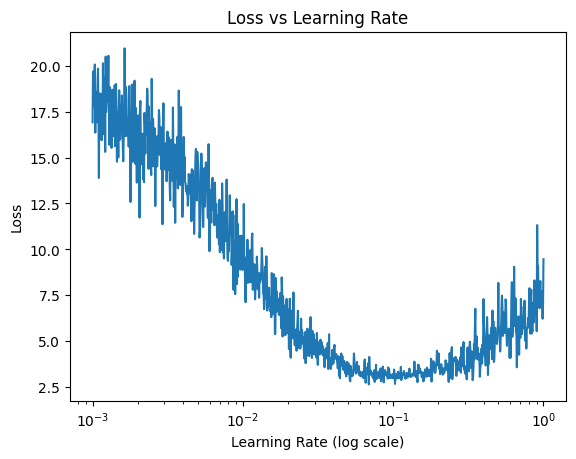

In [162]:
plt.plot(lri, lossi)
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Loss")
plt.title("Loss vs Learning Rate")
plt.xscale("log")
plt.show()

The ideal learning rate lies around 0.1.

In [165]:
# mode reset
params = create_model(
    embedding_dim=EMBEDDING_DIM,
    context_size=CONTEXT_SIZE,
    layer_size=LAYER_SIZE,
    n_token=n_token
)
C, W1, b1, W2, b2 = params

The model has 3,687 parameters.


In [166]:
LEARNING_RATE = 0.1

In [179]:
def train_model(params, learning_rate_decay=0.1, n_steps=10000):
    C, W1, b1, W2, b2 = params
    for _ in range(n_steps):
        # minibatch index
        ix = torch.randint(0, X.shape[0], (BATCH_SIZE,))  # Randomly sample BATCH_SIZE indices, shape (BATCH_SIZE,)

        # Forward pass
        h = torch.tanh(C[X[ix]].view((-1, EMBEDDING_DIM * CONTEXT_SIZE)) @ W1 + b1)  # shape (BATCH_SIZE, LAYER_SIZE)
        logits = h @ W2 + b2  # shape (BATCH_SIZE, n_token)
        loss = F.cross_entropy(logits, Y[ix])  # compute the cross-entropy loss

        # Backward pass
        for p in params:
            p.grad = None  # Reset gradients to zero before backpropagation
        loss.backward()  # Compute gradients

        # Update parameters using gradient descent
        for p in params:
            p.data -= LEARNING_RATE * learning_rate_decay * p.grad  # Update parameters with the defined learning rate

    # evaluate the final loss
    with torch.no_grad():
        h = torch.tanh(C[X].view((-1, EMBEDDING_DIM * CONTEXT_SIZE)) @ W1 + b1)  # shape (n_examples, LAYER_SIZE)
        logits = h @ W2 + b2  # shape (n_examples, n_token)
        loss = F.cross_entropy(logits, Y)  # compute the cross-entropy loss
        print(f"Final loss: {loss.item():,.3f}")  # Print the final loss value

In [ ]:
# one phase with the full learning rate and then a second phase with a lower learning rate
train_model(params, learning_rate_decay=1, n_steps=20000)
train_model(params, learning_rate_decay=0.1, n_steps=10000)

Final loss: 2.429
Final loss: 2.290
Final loss: 2.196


At this stage, the training phase is only evaluated on the training data. However, to truly assess the model's performance, we should also evaluate it on a validation set. This will help us understand how well the model generalizes to unseen data and prevent overfitting. Let's now re-write sone of the data processing codes to allow for the training set to be broken down into a training, a development, and a test set. The training set will be used to train the model, the development set will be used to tune the hyperparameters, and the test set will be used to evaluate the model's performance.

In [169]:
import random

def build_datasets(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Build datasets from a list of words by creating input and target tensors.
    
    Args:
        words (list[str]): List of words to build the datasets from.
        
    Returns:
        tuple[torch.Tensor, torch.Tensor]: Tuple containing the input tensor X and target tensor Y.
    """
    # Create a mapping from tokens to indices
    X, Y = [], []
    
    # Create the context for each character in the words
    for w in words:
        context = [0] * CONTEXT_SIZE
        for ch in w + SPECIAL_TOKEN:  # Add special token at the end
            ix = token_to_index[ch]
            X.append(context)
            Y.append(ix)
            if i < 3:
                print(''.join([index_to_token[i] for i in context]), '->', index_to_token[ix])
            # Update the context by shifting it and adding the new index 
            context = context[1:] + [ix]

    # Convert lists to tensors
    X = torch.tensor(X, dtype=torch.int64)
    Y = torch.tensor(Y, dtype=torch.int64)

    return X, Y
    
# Shuffle the words
random.seed(1234)
random.shuffle(birds)

# Split the dataset into training, development, and test sets
train_size = int(0.8 * len(birds))
dev_size = int(0.1 * len(birds))

X_train, Y_train = build_datasets(birds[:train_size])
X_dev, Y_dev = build_datasets(birds[train_size:train_size + dev_size])
X_test, Y_test = build_datasets(birds[train_size + dev_size:])

# print tensor shapes
print("Training set shape:", X_train.shape, Y_train.shape)
print("Development set shape:", X_dev.shape, Y_dev.shape)
print("Test set shape:", X_test.shape, Y_test.shape)


Training set shape: torch.Size([172513, 3]) torch.Size([172513])
Development set shape: torch.Size([21531, 3]) torch.Size([21531])
Test set shape: torch.Size([21461, 3]) torch.Size([21461])


In [170]:
# mode reset
params = create_model(
    embedding_dim=EMBEDDING_DIM,
    context_size=CONTEXT_SIZE,
    layer_size=LAYER_SIZE,
    n_token=n_token
)
C, W1, b1, W2, b2 = params

The model has 3,687 parameters.


In [ ]:
# train the model
# one phase with the full learning rate and then a second phase with a lower learning rate
train_model(params, learning_rate_decay=1, n_steps=20000)
train_model(params, learning_rate_decay=0.1, n_steps=10000)

Final loss: 2.428
Final loss: 2.276
Final loss: 2.172


In [172]:
# evaluate the final loss on the development set
with torch.no_grad():
    h = torch.tanh(C[X_dev].view((-1, EMBEDDING_DIM * CONTEXT_SIZE)) @ W1 + b1)  # shape (n_examples, LAYER_SIZE)
    logits = h @ W2 + b2  # shape (n_examples, n_token)
    loss = F.cross_entropy(logits, Y_dev)  # compute the cross-entropy loss
    print(f"Final loss: {loss.item():,.3f}")  # Print the final loss value

Final loss: 2.173


The train loss and dev loss are almost identical. This suggests that the model is generalizing well and not overfitting to the training data.
When the training loss and the dev loss are close to each other, it indicates that the model is underfitting. This means that the model is not complex enough to capture the underlying patterns in the data. One solution to this problem is to increase the model's capacity by adding more layers or increasing the number of neurons in the hidden layer.

In [188]:
# reset the size of the hidden layer
LAYER_SIZE = 500

# mode reset
params = create_model(
    embedding_dim=EMBEDDING_DIM,
    context_size=CONTEXT_SIZE,
    layer_size=LAYER_SIZE,
    n_token=n_token
)
C, W1, b1, W2, b2 = params

The model has 18,087 parameters.


In [192]:
# train the model
# one phase with the full learning rate and then using lower learning rates
train_model(params, learning_rate_decay=1, n_steps=70000)
train_model(params, learning_rate_decay=0.5, n_steps=20000)
train_model(params, learning_rate_decay=0.1, n_steps=10000)

Final loss: 1.751
Final loss: 1.551
Final loss: 1.424


In [193]:
# evaluate the final loss on the development set
with torch.no_grad():
    h = torch.tanh(C[X_dev].view((-1, EMBEDDING_DIM * CONTEXT_SIZE)) @ W1 + b1)  # shape (n_examples, LAYER_SIZE)
    logits = h @ W2 + b2  # shape (n_examples, n_token)
    loss = F.cross_entropy(logits, Y_dev)  # compute the cross-entropy loss
    print(f"Final loss: {loss.item():,.3f}")  # Print the final loss value

Final loss: 1.421


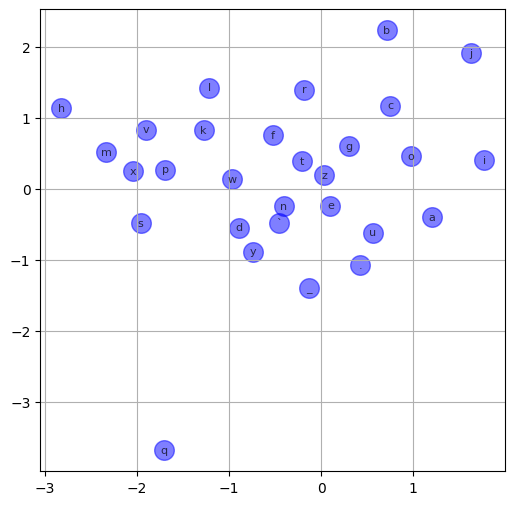

In [197]:
# visualize the embeddings
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(C[:, 0].data, C[:, 1].data, c='blue', alpha=0.5, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), index_to_token[i], fontsize=8, alpha=0.7, ha='center', va='center', color='black')

plt.grid('minor')


From the above chart, we can see that:
- all the vowels are clustered together along the same line, which is expected as they are all similar characters.
- `"q"` is isolated from the other characters, which is also expected as it is a rare character.

Let's now increase the embedding dimension to 64 and re-run the training. This will allow the model to learn more complex patterns in the data and improve its performance.

In [217]:
# reset the size of the hidden layer
LAYER_SIZE = 500
EMBEDDING_DIM = 10

# mode reset
params = create_model(
    embedding_dim=EMBEDDING_DIM,
    context_size=CONTEXT_SIZE,
    layer_size=LAYER_SIZE,
    n_token=n_token
)
C, W1, b1, W2, b2 = params

The model has 30,319 parameters.


In [218]:
# train the model
# one phase with the full learning rate and then using lower learning rates
train_model(params, learning_rate_decay=1, n_steps=100000)
train_model(params, learning_rate_decay=0.5, n_steps=20000)
train_model(params, learning_rate_decay=0.1, n_steps=20000)

Final loss: 1.576
Final loss: 1.337
Final loss: 1.241


In [219]:
# evaluate the final loss on the development set
with torch.no_grad():
    h = torch.tanh(C[X_dev].view((-1, EMBEDDING_DIM * CONTEXT_SIZE)) @ W1 + b1)  # shape (n_examples, LAYER_SIZE)
    logits = h @ W2 + b2  # shape (n_examples, n_token)
    loss = F.cross_entropy(logits, Y_dev)  # compute the cross-entropy loss
    print(f"Final loss: {loss.item():,.3f}")  # Print the final loss value

Final loss: 1.230


We can now sample new bird names from the model. The model will generate a sequence of characters based on the context and the learned patterns in the data. The generated sequence will be a valid bird name, as it will follow the same patterns as the training data.

In [223]:
# sample new bird names from the model
for i in range(10):
    context = [0] * CONTEXT_SIZE
    out = []
    while True:
        # Convert context to tensor and get embeddings
        context_tensor = torch.tensor(context, dtype=torch.int64).unsqueeze(0)  # shape (1, CONTEXT_SIZE)
        h = torch.tanh(C[context_tensor].view((-1, EMBEDDING_DIM * CONTEXT_SIZE)) @ W1 + b1)  # shape (1, LAYER_SIZE)
        logits = h @ W2 + b2  # shape (1, n_token)
        probs = F.softmax(logits, dim=1)  # shape (1, n_token)

        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()  # Get the index of the sampled token
        out.append(index_to_token[ix])  # Append the token to the output

        if ix == token_to_index[SPECIAL_TOKEN]:  # Stop if we hit the special token
            break

        # Update the context by shifting it and adding the new index 
        context = context[1:] + [ix]

    print(''.join(out))  # Print the generated bird name

white_earwater.
blackered_eaglaughing.
paler.
southat.
flamed_scopknia.
hoftta.
commonary.
long_thicker.
ochrike_vireo.
monduline_fantshrike.


## References

- Yoshua Bengio, Réjean Ducharme, Pascal Vincent, and Christian Janvin. 2003. A neural probabilistic language model. J. Mach. Learn. Res. 3, null (3/1/2003), 1137–1155.